# Analysis1. How the tokens contribute to the answer generation

### Analysis 1. 1. load data


In [7]:
import config_env
import pickle as pkl
import re
import json
import networkx as nx
import os

name = 'Qwen3-0.6B'
train_dataset_name = 'gsm8k'
edge_ratio = 0.45
node_ratio = 0.4
l1_co = 0.00005

save_json = f'./data_{train_dataset_name}/{name}_answer.json'
with open(save_json,'r') as f:
    test_data = json.load(f)
    
save_path = f'/egr/research-dselab/shared/daixinna/GLLM/{name}_{train_dataset_name}_{edge_ratio}_{node_ratio}_{l1_co}/'
files = [int(f.split('.')[0]) for f in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, f))]
print('generated idx files')
print(files)

correct_data_list = []
correct_ans = []
for idx in files:
    with open(save_path + f'{idx}.pkl', 'rb') as f:
        data = pkl.load(f)
        correct_data_list.append(data)
        correct_ans.append([test_data[idx]['ans']])
correct_data_list = correct_data_list# [:10]

select_num = 28
G_correct = nx.DiGraph()
data = correct_data_list[select_num]
print(correct_ans[select_num])
color_map = []
word_marker_collect = []
for key_words in data.keys():
    if key_words == '**ans**':
        print(data[key_words])
        continue
    # print(data[key_words])
    for key_pos in data[key_words].keys():
        key = f'{key_words}'
        for neuron in data[key_words][key_pos]:
            word, layer, pos, ans_flag = neuron.split('_')
            word_marker_collect.append(f'{word}_{pos}')
            if key_pos == 'last':
                ans = data['**ans**']
                word = f'{ans}_ans'
            else:
                word = f'{word}_{ans_flag}'
            G_correct.add_edge(f'{key}_1', word)

word_marker_collect = list(set(word_marker_collect))




generated idx files
[131, 195, 30, 103, 178, 104, 66, 169, 112, 160, 167, 14, 152, 184, 127, 120, 105, 71, 170, 142, 31, 36, 194, 137, 95, 121, 126, 84, 55, 128, 185, 182, 166, 15, 161, 113, 67, 168, 125, 56, 181, 24, 186, 64, 117, 110, 108, 197, 190, 40, 6, 133, 134, 148, 96, 1, 118, 10, 156, 88, 180, 22, 123, 124, 158, 135, 149, 132, 191, 140, 34, 109]
["Question: Jean has 30 lollipops. Jean eats 2 of the lollipops. With the remaining lollipops, Jean wants to package 2 lollipops in one bag. How many bags can Jean fill?\nLet's think step by step\nAnswer:\nStep 1: Jean starts with 30 lollipops.\nStep 2: Jean eats 2 lollipops, so she has 30 - 2 = 28 lollipops left.\nStep 3: She wants to package 2 lollipops in each bag. \nStep 4: To find out how many bags she can fill, divide the remaining lollipops by the number of lollipops per bag: 28 / 2 = 14.\nAnswer: 14 bags.\nStep-by-step explanation:\n\nStep 1: Jean starts with 30 lollipops.\nStep 2: Jean eats 2 lollipops, so she has 30 - 2 = 28 

In [9]:
# selected question and it's answer
ans = correct_ans[select_num][0]
def get_text_before_second_question_correct(text):
    sub = 'Answer:'
    text = text.split(sub)[0] + sub +  text.split(sub)[1]  
    return text
# print(ans)
ans = get_text_before_second_question_correct(ans)
print(ans)

Question: Jean has 30 lollipops. Jean eats 2 of the lollipops. With the remaining lollipops, Jean wants to package 2 lollipops in one bag. How many bags can Jean fill?
Let's think step by step
Answer:
Step 1: Jean starts with 30 lollipops.
Step 2: Jean eats 2 lollipops, so she has 30 - 2 = 28 lollipops left.
Step 3: She wants to package 2 lollipops in each bag. 
Step 4: To find out how many bags she can fill, divide the remaining lollipops by the number of lollipops per bag: 28 / 2 = 14.



### Analysis 1.2(optional) token relations in a sentence

54
54


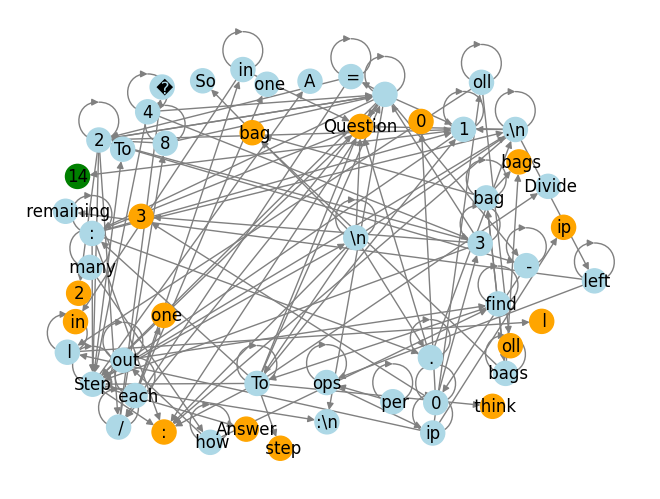

In [8]:
print(len(G_correct.nodes))
node_labels = {}
for idx, node in enumerate(G_correct.nodes):
    if node.endswith('_1'):
        color_map.append('lightblue')
    elif node.endswith('_ans'):
        color_map.append('green')
    else:
        color_map.append('orange')
    node_label = node.split('_')[0]
    node_label = node_label.replace('\n','\\n')
    node_labels[node] = node_label
    
print(len(G_correct.nodes))

import matplotlib.pyplot as plt
pos = nx.spring_layout(G_correct, k=1, iterations=10)
nx.draw(G_correct, pos, with_labels=False, node_color=color_map, edge_color='gray')

# labels = nx.get_node_attributes(G_correct, "label")
nx.draw_networkx_labels(G_correct, pos, labels=node_labels,  font_size=12)
plt.show()

### Analysis 1.3 How LLMs generate a chain of thought

In [11]:
# set the word (token) connections
from model_load import load_model, model_name_func
model_name = model_name_func(name)
model = load_model(name)
tokenizer = model.tokenizer
tokens = tokenizer(ans, return_offsets_mapping=True)
offsets = tokens['offset_mapping']


input_ids = tokens['input_ids']
pos_dicts = {}
pos_sets = []
last_set = len(offsets) - 3
for key_words in data.keys():
    if key_words == '**ans**':
        print(data[key_words])
        continue
    for key_pos in data[key_words].keys():
        key = f'{key_words}'
        
        for neuron in data[key_words][key_pos]:
            word, layer, pos, ans_flag = neuron.split('_')
            if int(pos) not in pos_dicts:
                pos_dicts[int(pos)] = []
            
            pos_sets.append(int(pos))
            if key_pos == 'last':
                pos_dicts[int(pos)].append(last_set)
                pos_sets.append(last_set )
                print(int(pos),last_set)
            else:    
                pos_dicts[int(pos)].append(key_pos)
                pos_sets.append(key_pos)
for key in pos_dicts.keys():
    pos_dicts[key] = list(set(pos_dicts[key]))
    
pos_dicts


Loaded pretrained model Qwen/Qwen3-0.6B into HookedTransformer
14
0 167
0 167
166 167
166 167
0 167
0 167
166 167


{0: [131, 126, 167, 107, 77, 125, 122, 61, 158, 159],
 166: [167],
 61: [64, 131, 107, 108, 77, 78, 109, 76, 75, 127, 62, 63],
 62: [131, 63],
 165: [166],
 162: [163, 164, 165],
 95: [96, 97],
 158: [159],
 98: [99, 165],
 127: [128, 129],
 63: [64, 131, 107, 75, 77, 109, 78],
 108: [109, 110, 127],
 78: [109, 110],
 60: [61, 77],
 76: [107, 108, 77, 78, 127],
 1: [131, 107, 77, 158, 61, 126],
 164: [165],
 97: [98],
 161: [162],
 117: [164],
 163: [164],
 96: [97],
 83: [97],
 36: [117],
 116: [117],
 82: [83],
 15: [83],
 159: [160],
 100: [160, 101],
 99: [100, 101],
 77: [78],
 160: [161],
 101: [161, 102],
 94: [95],
 70: [94, 71],
 93: [94],
 69: [70, 93, 94],
 6: [70],
 5: [69, 93, 70],
 92: [93],
 68: [69],
 109: [110],
 157: [158],
 64: [130],
 129: [130],
 124: [136, 125, 157],
 43: [136, 124, 157],
 136: [157],
 47: [136, 124, 157],
 156: [157],
 123: [124],
 155: [156],
 135: [136],
 42: [123],
 122: [123],
 73: [74],
 104: [105],
 134: [135],
 41: [122],
 121: [122],
 133

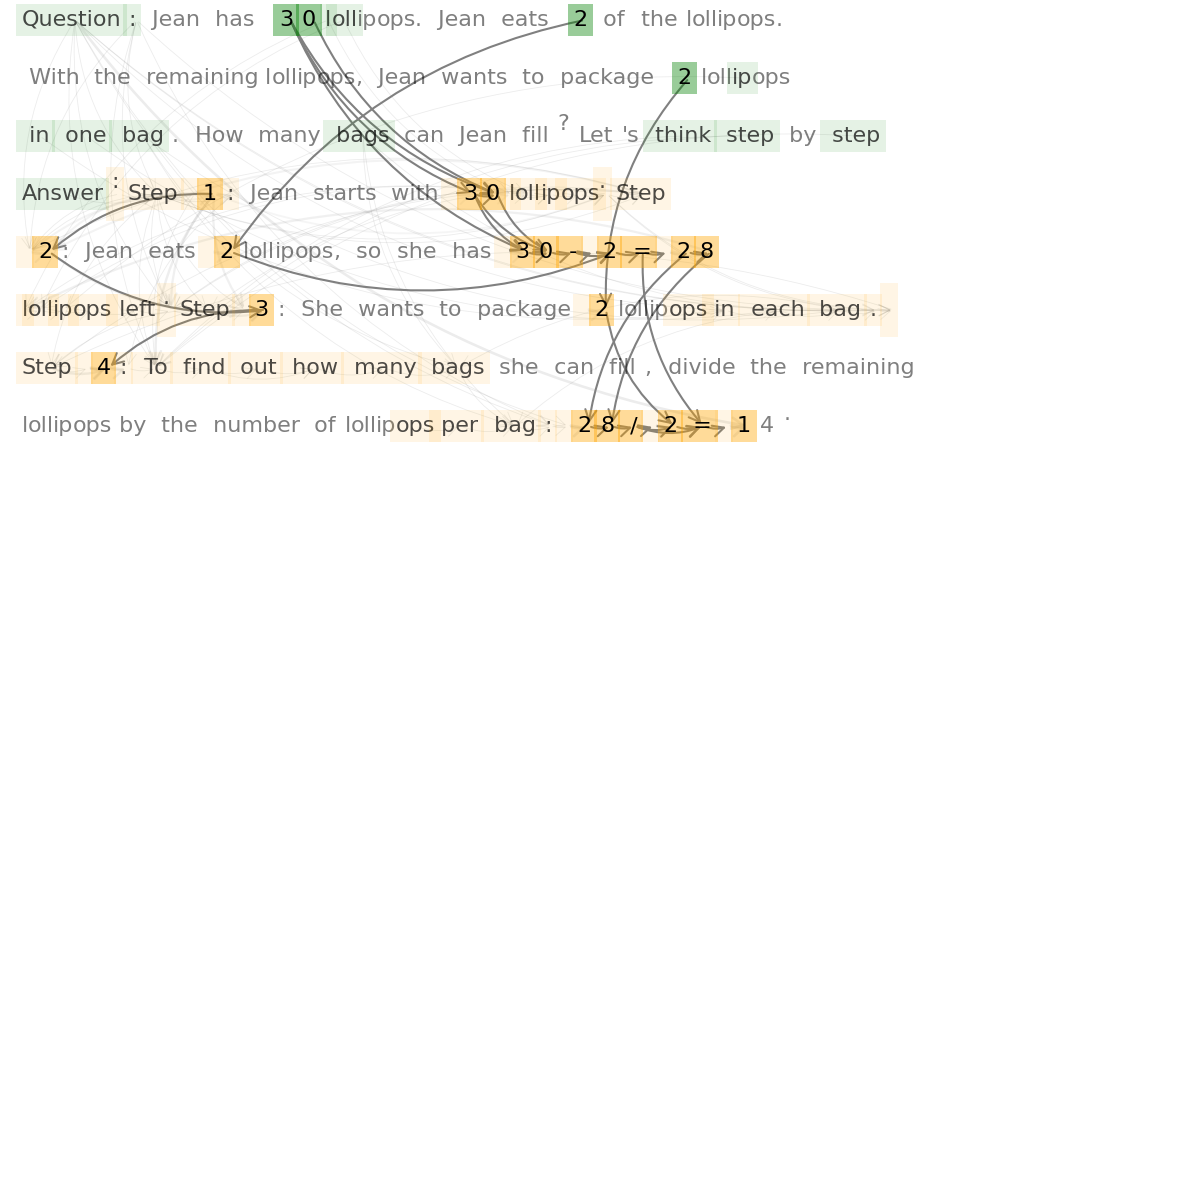

In [12]:
# visualization
current_token = ''
highlight_idx = {}
highlight_line_idx = {}
highlight_ids = {}
line_count = 0
highlight_idx[line_count] = []
highlight_ids[line_count] = []
highlight_line_idx[line_count] = []
pos_reid = {}
pos_reid[line_count] = []
# for idx, token_slice in enumerate(offsets):
def search_highlight_words_pos(pos_ids, idx):
    for p in pos_ids:
        if isinstance(p, int):
            if p == idx:
                return True
    return False

line_width_token_max = 23
cal_lens = 0

for idx, token_idx in enumerate(input_ids):
    highlight_line_idx[line_count].append(token_idx)
    pos_reid[line_count].append(idx)
    if search_highlight_words_pos(pos_sets, idx):
        highlight_idx[line_count].append(idx)
        highlight_ids[line_count].append(token_idx)

    cal_lens += 1
    if cal_lens >= line_width_token_max:
        cal_lens = 0 
        line_count += 1
        highlight_idx[line_count] = []
        highlight_line_idx[line_count] = []
        highlight_ids[line_count] = []
        pos_reid[line_count] = []
    # adjust the lines in visualization
    if line_count == 1:
        line_width_token_max = 18
    if line_count == 4:
        line_width_token_max = 25
    if line_count == 6:
        line_width_token_max = 17
    if line_count == 7:
        line_width_token_max = 30

line_spacing = 0.05
mid_space = 0.008
mid_space_merged = 0.0
fig, ax = plt.subplots(figsize=(12, 12))

ax.axis("off")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
highlight_color = "green"
highlight_positions = []
highlight_idx_mark = {}

renderer = fig.canvas.get_renderer()  

merged_tokens = [' l','oll','ip','ops'] # this word is split by the tokenizer
symbol_list = [' +',' -',' *',' =',' /']

for step_idx, i in enumerate(pos_reid.keys()):
    x, y = 0.01, 1 - i * line_spacing 
    for ids in pos_reid[i]:
        token = tokenizer.decode(input_ids[ids])
        # print(token)
        if token in merged_tokens:
            token = token.replace(' ','')
            take_midle = mid_space_merged
        else:
            take_midle = mid_space
        if token.isdigit() or token in symbol_list:
            alpha = 0.4
        else: alpha = 0.1
        if ids in highlight_idx[i]:
            text_obj = ax.text(
                x, y, token, fontsize=16, va="center", ha="left",alpha=alpha+0.6,
                bbox=dict(facecolor=highlight_color, alpha=alpha, edgecolor="none")
            )
        else:
            text_obj = ax.text(
                x, y, token, fontsize=16, va="center", ha="left",alpha=0.5
            )

        bbox = text_obj.get_window_extent(renderer=renderer)
        token_width = bbox.width / fig.dpi / fig.get_size_inches()[0] 
        x += token_width  + take_midle
        if 'Answer' in token:
            highlight_color = 'orange'

        if ids in highlight_idx[i]:
            center_x = x - (token_width + take_midle) / 2
            center_y = y
            highlight_positions.append((center_x, center_y, token, step_idx))
            highlight_idx_mark[ids] = (center_x, center_y, token, step_idx)

import matplotlib.patches as patches
arrow_color="grey"

for key in pos_dicts.keys():
    for end_p in pos_dicts[key]:
        if key in highlight_idx_mark and end_p in highlight_idx_mark:
                start_x, start_y, start_token, start_line = highlight_idx_mark[key]
                end_x, end_y, end_token, end_line = highlight_idx_mark[end_p]


                d1 = start_token.isdigit() # or start_token in symbol_list
                d2 = end_token.isdigit() # or end_token in symbol_list
                if d1 and d2:
                    alpha = 1
                    lines = 1.5 # + end_line/len(pos_reid.keys())
                    # alpha = alpha * (end_line+1)/len(pos_reid.keys())
                elif d1 or d2:
                    alpha = 0.15
                    alpha = alpha * (end_line+1)/len(pos_reid.keys())
                    lines = 1 + end_line/len(pos_reid.keys())
                else: 
                    alpha = 0.15
                    lines = 0.6
                
                if start_token in symbol_list or end_token in symbol_list:
                    alpha = 1
                    # lines = 1.2
                    lines = 1.5 # + end_line/len(pos_reid.keys())

                arrow = patches.FancyArrowPatch(
                    (start_x, start_y), (end_x, end_y),
                    connectionstyle="arc3,rad=0.2",  
                    arrowstyle="->",
                    mutation_scale=20,
                    color=arrow_color,
                    alpha=alpha,
                    linewidth=lines
                )
                ax.add_patch(arrow)
        else:
            print('not in',key, end_p)
plt.tight_layout()
plt.show()

# Analysis 2 How LLMs organize and structure information from a given dataset

Instead of analyzing only a single sample, we also analyze how LLMs perform across an entire dataset, allowing us to identify common patterns and shared behaviors across samples. We call this global view as **GraphGhost**


In [1]:
from tqdm import tqdm
## graph building method for the entire dataset
def get_token_level_graph(data_graph_list, max_depth = 30):
    '''
    several version of building graph. However, the best way to define the graph also need to be explored
    '''
    global_graph = nx.DiGraph()
    global_graph_without_logit = nx.DiGraph()
    global_graph_with_logit = nx.DiGraph()
    inner_graphs = nx.DiGraph()
    counts = 0
    subgraphs = []
    for idx, graph_data in tqdm(enumerate(data_graph_list), total=len(data_graph_list)):
        flag = 1
        if counts == 100:break # select 100 samples to generate the 
        if len(graph_data) <= 5: continue
        
        for g in graph_data:
            subgraph = nx.DiGraph()
            for edge in list(g.edges()):
                try:
                    s_word, s_layer, _ = edge[0].split('_')
                    e_word, e_layer, _ = edge[1].split('_')
                except:
                    continue

                ls = int(s_layer) + 2 if s_layer.isdigit() else 1
                le = int(e_layer) + 2 if e_layer.isdigit() else 1
                d = (max_depth/ls + max_depth/le) / 2
                weights = 1 / (1 + d)

                if ls < max_depth + 1 and le < max_depth+1: 
                    u = f'{e_word}_{e_layer}'
                    v = f'{s_word}_{s_layer}'
                    if global_graph_without_logit.has_edge(u, v):
                        global_graph_without_logit[u][v]['weight'] += 1
                    else:
                        global_graph_without_logit.add_edge(u, v, weight=1)

                if ls == max_depth + 1 or le == max_depth+1: 
                    v = f'{e_word}_{e_layer}'
                    u = f'{s_word}_{s_layer}'
                else:
                    u = f'{e_word}_{e_layer}'
                    v = f'{s_word}_{s_layer}'
                if global_graph.has_edge(u, v):
                    global_graph[u][v]['weight'] += 1
                else:
                    global_graph.add_edge(u, v, weight=1)
                u = f'{e_word}_{e_layer}'
                v = f'{s_word}_{s_layer}'
                if global_graph_with_logit.has_edge(u, v):
                    global_graph_with_logit[u][v]['weight'] += 1
                else:
                    global_graph_with_logit.add_edge(u, v, weight=1)
        counts += 1
    print(counts)
    return global_graph, global_graph_without_logit, global_graph_with_logit


In [18]:
import os
import networkx as nx
import pickle as pkl

name = 'Qwen3-0.6B' 
train_dataset_name = 'gsm8k'
edge_ratio = 0.5
node_ratio = 0.4
l1_co = 0.00005
layers = 30 # include the embedding and logit layer
save_path = f'/egr/research-dselab/shared/daixinna/GLLM/{name}_{train_dataset_name}_{edge_ratio}_{node_ratio}_{l1_co}/'
save_graph_path = f'/egr/research-dselab/shared/daixinna/GLLM/graph_{name}_{train_dataset_name}_{edge_ratio}_{node_ratio}_{l1_co}/'
data_graph_idx = []
data_graph_list = []
for files in os.listdir(save_graph_path):
    with open(save_graph_path + f'{files}', 'rb') as f:
        data = pkl.load(f)
    data_graph_list.append(data)
    data_graph_idx.append(int(files.split('.')[0]))


print(data_graph_idx)
len(data_graph_list)

G3, G3_inv,G_with_logit = get_token_level_graph(data_graph_list, max_depth= layers)


[227, 646, 10, 475, 472, 1058, 400, 229, 648, 634, 1064, 260, 449, 1063, 435, 22, 447, 269, 674, 215, 59, 88, 673, 212, 105, 25, 440, 491, 662, 48, 1, 480, 451, 34, 619, 6, 487, 456, 33, 665, 204, 458, 610, 271, 238, 659, 625, 411, 74, 998, 231, 650, 686, 213, 104, 24, 490, 268, 103, 1062, 80, 433, 56, 600, 254, 253, 632, 64, 221, 408, 647, 474, 656, 419, 465, 230, 651, 623, 239, 72, 96, 270, 616, 488, 40, 425, 618, 279, 486, 32, 664, 481, 461, 233, 78, 655, 248, 71, 627, 994, 241, 274, 208, 669, 95, 421, 482, 36, 4, 485, 31, 667, 217, 210, 671, 27, 442, 1068, 55, 84, 109, 29, 262, 1061, 437, 678, 631, 67, 60, 405, 257, 225, 638, 470, 69, 222, 484, 30, 429, 200, 661, 452, 420, 272, 613, 209, 42, 1044, 240, 469, 654, 235, 685, 653, 232, 79, 471, 14, 68, 223, 224, 476, 639, 478, 637, 630, 251, 66, 1060, 436, 82, 218, 679, 431, 108, 263, 1067, 602, 211, 26, 492, 216, 677]


 55%|█████▌    | 101/183 [00:01<00:01, 77.16it/s]

100


In [20]:
# page rank applying for analysis
G_norm3 = nx.stochastic_graph(G3, weight="weight")
pr3 = nx.pagerank(G_norm3, weight="weight")
sorted_pr3 = sorted(pr3.items(), key=lambda x: x[1], reverse=True)
sorted_pr3[:20]

[(' the_27', 0.0024132189000125306),
 ('0_27', 0.0018948837965142846),
 (' _27', 0.0018317639366217382),
 ('._27', 0.0018186730933958401),
 (' the_26', 0.0015995258747173566),
 (' **_27', 0.0012209677824512083),
 (':_27', 0.0011754545497149637),
 (' of_26', 0.001104008518735756),
 (' (_27', 0.0009732231400974444),
 (' the_25', 0.0009584368209890447),
 ('._24', 0.0009515457545781516),
 (',_27', 0.0009315773149493872),
 (',_26', 0.0009167490524460349),
 (' to_26', 0.0009145329356054525),
 ('._26', 0.0008759065315006492),
 ('\n_27', 0.0008463553084933804),
 ('0_26', 0.0008435537585642381),
 (' the_23', 0.0008260142126647144),
 (' to_25', 0.0008109852433334821),
 (' the_22', 0.0008046037581918289)]

# Analysis 3. Pertube the questions via contribution tokens 
(according to Analysis1)

The model would still reasoning correct only rely on some contribution tokens, although after delete some tokens, the semantic is not complete.

In [1]:
import config_env
import random
import os
import pickle as pkl
import re
import json
from model_load import load_model, model_name_func
from datasets import load_dataset
cache_root = "/egr/research-dselab/daixinna/shared/huggingface_path"
device = '1'
os.environ["CUDA_VISIBLE_DEVICES"] = device
name =  'Qwen3-0.6B'
edge_ratio = 0.5
node_ratio = 0.4
l1_co = 0.00005
train_dataset_name = 'gsm8k'
data_idx = []
data_list = []
save_path = f'/egr/research-dselab/shared/daixinna/GLLM/{name}_{train_dataset_name}_{edge_ratio}_{node_ratio}_{l1_co}/'
for files in os.listdir(save_path):
    with open(save_path + f'{files}', 'rb') as f:
        data = pkl.load(f)
    data_list.append(data)
    data_idx.append(int(files.split('.')[0]))
dataset = load_dataset("gsm8k", "main", cache_dir=cache_root)
test = dataset["test"]
model_name =  model_name_func(name)# 'meta-llama/Llama-3.2-1B'# "Qwen/Qwen2.5-1.5B"
model = load_model(name)
tokenizer = model.tokenizer

unk_id = tokenizer(' ', return_tensors="pt")["input_ids"][0]


def generate_gsm8k(data):
    question, ans = data['question'], data['answer']
    prompt = "Question: " + str(question) + "\nLet's think step by step\nAnswer:\n"
    max_token = 300
    return question, prompt, ans, max_token

save_json = f'./data_{train_dataset_name}/{name}_answer.json'
with open(save_json,'r') as f:
    test_data = json.load(f)

files = [int(f.split('.')[0]) for f in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, f))]
print('available idx (we\'ve run attribution graph file on these samples)')
print(files)

`torch_dtype` is deprecated! Use `dtype` instead!


Loaded pretrained model Qwen/Qwen3-0.6B into HookedTransformer
available idx (we've run attribution graph file on these samples)
[26, 239, 366, 623, 230, 651, 82, 465, 656, 419, 481, 664, 618, 66, 279, 486, 14, 425, 616, 68, 488, 270, 600, 433, 79, 103, 268, 490, 104, 213, 474, 408, 1062, 647, 221, 42, 30, 253, 632, 254, 370, 610, 271, 69, 458, 665, 204, 619, 67, 456, 487, 60, 451, 480, 662, 84, 55, 686, 29, 231, 650, 998, 411, 625, 238, 27, 659, 360, 634, 36, 229, 648, 400, 376, 31, 4, 1064, 472, 475, 95, 227, 1063, 646, 491, 440, 71, 105, 673, 212, 674, 215, 447, 269, 435, 449, 78, 260, 1058, 32, 197, 630, 251, 478, 637, 372, 476, 639, 96, 224, 1060, 1067, 223, 471, 40, 216, 677, 492, 72, 211, 263, 602, 431, 108, 436, 218, 679, 209, 351, 272, 613, 420, 452, 1044, 200, 661, 429, 64, 484, 653, 232, 80, 56, 685, 654, 235, 469, 24, 240, 437, 678, 262, 109, 442, 210, 671, 217, 74, 6, 222, 470, 638, 1, 1061, 225, 257, 48, 405, 34, 33, 1068, 631, 196, 22, 994, 241, 88, 627, 180, 59, 25, 248

In [8]:


idx = 230
data_dicts = data_list[data_idx.index(idx)]
data = test[idx]
question, prompt, ans, max_token = generate_gsm8k(data)
question_tokens = tokenizer(prompt, return_tensors="pt")
ori_ans = test_data[idx]['ans']
print('original answer')
print(ori_ans)
known_pos = []
masked_pos = []
input_ids = question_tokens ["input_ids"].clone()
random_input_ids = question_tokens ["input_ids"].clone()
for node in data_dicts.keys():
    if node == '**ans**':
        continue
    double_check = set()

    for key in data_dicts[node].keys():
        for words in data_dicts[node][key]:
            words, layer, pos, flag = words.split('_')
            pos = int(pos)
            known_pos.append(pos)

for i in range(input_ids.shape[1]):
    if i not in known_pos:
        masked_pos.append(i)

marked_pos_count = 0 
for pos in masked_pos:
    if pos < input_ids.shape[1]:
        input_ids[0, pos] = unk_id
        marked_pos_count += 1
for i in range(marked_pos_count):
    random_inc = random.randint(0, input_ids.shape[1]-1)
    random_input_ids[0, random_inc] = unk_id

    
sparsity = 1 - marked_pos_count/input_ids.shape[1]
print('idx',idx,'sparsity',sparsity)

new_text = tokenizer.decode(input_ids[0])
random_new_text = tokenizer.decode(random_input_ids[0])

generated_text = model.generate(
    new_text,
    max_new_tokens=max_token,   
    temperature=0,      
)
print('after only keep the contribution tokens')
print(generated_text)

random_generated_text = model.generate(
    random_new_text,
    max_new_tokens=max_token,   
    temperature=0,     
)
print('random delete the tokens')
print(random_generated_text)

original answer
Question: Mark buys a fleet of 12 cars for his company.  Each car sells for $20,000.  He pays 10% tax on the cars and then another $1000 for registration on each of them.  How much does he pay for everything?
Let's think step by step
Answer:
Step 1: Calculate the total cost of the cars before tax and registration.
Each car costs $20,000, and there are 12 cars.
Total cost = 12 * $20,000 = $240,000.

Step 2: Calculate the tax on the cars.
Tax is 10% of the total cost.
Tax = 10% * $240,000 = $24,000.

Step 3: Calculate the registration cost for all cars.
Registration cost is $1000 per car.
Total registration cost = 12 * $1000 = $12,000.

Step 4: Add up all the costs to find the total amount paid.
Total amount paid = Total cost + Tax + Registration cost
Total amount paid = $240,000 + $24,000 + $12,000 = $276,000.

Answer: $276,000
Step-by-Step Explanation:
1. Calculate the total cost of the cars: 12 * $20,000 = $240,000.
2. Calculate the tax: 10% of $240,000 = $24,000.
3. C

  0%|          | 0/300 [00:00<?, ?it/s]

after only keep the contribution tokens
Question: Mark buys  fleet  12 cars  his    Each car sells  $20,000   He pays 10% tax on  cars    $1000 for registration  each     How much   pay      think   step Answer:
Step-by-step explanation:
Step 1: Calculate the total cost of the 12 cars. Each car costs $20,000, so 12 cars would cost 12 * 20,000 = $240,000.

Step 2: Calculate the total tax paid. The tax is 10% of the total cost. So, 10% of $240,000 is $24,000.

Step 3: Add the registration fee to the total tax. The registration fee is $1,000. So, the total amount paid is $24,000 + $1,000 = $25,000.

Step 4: The answer is $25,000.
Answer: $25,000
Step-by-step explanation:
Step 1: Calculate the total cost of the 12 cars. Each car costs $20,000, so 12 cars would cost 12 * 20,000 = $240,000.

Step 2: Calculate the total tax paid. The tax is 10% of the total cost. So, 10% of $240,000 is $24,000.

Step 3: Add the registration fee to the total


  0%|          | 0/300 [00:00<?, ?it/s]

random delete the tokens
Question   buys a fleet of 1  cars  his .   car sells for $2 ,000.  He    % tax on the  and then another $ 0 0 for registration on  of them   How  does he pay  everything?
    step  step
Answer:
Step 1: Calculate the total cost of the cars.
Step 2: Add the registration fee.
Step 3: Add the tax.
Step 4: Add the total cost to the registration fee.
Step 5: Add the total cost to the tax.
Step 6: Add the total cost to the registration fee and tax.
Step 7: Add the total cost to the registration fee and tax.
Step 8: Add the total cost to the registration fee and tax.
Step 9: Add the total cost to the registration fee and tax.
Step 10: Add the total cost to the registration fee and tax.
Step 11: Add the total cost to the registration fee and tax.
Step 12: Add the total cost to the registration fee and tax.
Step 13: Add the total cost to the registration fee and tax.
Step 14: Add the total cost to the registration fee and tax.
Step 15: Add the total cost to the registra

# Analysis 4. Pertube the LLMs with the global understanding of the dataset


### Analysis 4.1. setup the environment

In [ ]:
import config_env
import os
import torch
import time

import random
from tqdm import tqdm
import pickle as pkl
import re
import json
import networkx as nx
from model_load import load_model, model_name_func

from datasets import load_dataset
device = '1'
os.environ["CUDA_VISIBLE_DEVICES"] = device
name = 'Qwen3-0.6B' 
train_dataset_name = 'gsm8k'
top_k = 1
top_down = None
selected_method = 'delete'


edge_ratio = 0.5
node_ratio = 0.4
alpha = 1
l1_co = 0.00005
save_path = f'/egr/research-dselab/shared/daixinna/GLLM/{name}_{train_dataset_name}_{edge_ratio}_{node_ratio}_{l1_co}/'
save_graph_path = f'/egr/research-dselab/shared/daixinna/GLLM/graph_{name}_{train_dataset_name}_{edge_ratio}_{node_ratio}_{l1_co}/'
import os
idx_list = []
files = [int(f.split('.')[0]) for f in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, f))]
data_graph_idx = []
data_graph_list = []
for files in os.listdir(save_graph_path):
    with open(save_graph_path + f'{files}', 'rb') as f:
        data = pkl.load(f)
    data_graph_list.append(data)
print(len(files))


save_json = f'./data_{train_dataset_name}/{name}_answer.json'
with open(save_json,'r') as f:
    test_data = json.load(f)

data_idx = []
data_list = []
for files in os.listdir(save_path):
    with open(save_path + f'{files}', 'rb') as f:
        data = pkl.load(f)
    data_list.append(data)
    data_idx.append(int(files.split('.')[0]))
len(data_list)
model_name =  model_name_func(name)
model = load_model(name)
tokenizer = model.tokenizer




7


`torch_dtype` is deprecated! Use `dtype` instead!


Loaded pretrained model Qwen/Qwen3-0.6B into HookedTransformer


### Step4.2 according to the GraphGhost, setup the guidelines for LLMs in muting or rewiring the inner neurons

We delete neuron node "the_17" as an example. This means that LLMs will mute neurons at layer 17 when they read the token "the"

In [4]:
from pertube import rewire_token_terminal
neuron_node = ' the_17' 
G, G_wo_logit, _ = get_token_level_graph(data_graph_list, max_depth=model.cfg.n_layers+2)
read_rewired_dict = rewire_token_terminal(G, neuron_node, model.cfg.n_layers)

print(read_rewired_dict)
print('get rewired dicts')

# sparsity_list = []
token_layer_dicts = {}
for idx, key in enumerate(read_rewired_dict.keys()):
    word, layer = key.split('_')
    tokens = tokenizer(word)['input_ids']
    layer = int(layer)
    token_layer_dicts[(layer, tokens[-1])] = []
    for edge_pairs in read_rewired_dict[key]:
        # print(edge_pairs)
        word_old, layer_old = edge_pairs[0].split('_')
        word_new, layer_new = edge_pairs[1].split('_')
        token_old = tokenizer(word_old)['input_ids']
        token_new = tokenizer(word_new)['input_ids']
        
        layer_old = int(layer_old)
        if layer_old > model.cfg.n_layers: 
            layer_old = model.cfg.n_layers # 'logits'
        layer_new = int(layer_new)
        if layer_new > model.cfg.n_layers: 
            layer_new = model.cfg.n_layers # 'logits'
        token_layer_dicts[(layer, tokens[-1])].append([(layer_old, token_old[-1]), (layer_new, token_new[-1])])
        # break

print(token_layer_dicts)

 55%|█████▌    | 101/183 [00:01<00:01, 81.92it/s]


100
(' time_29', ' the_17')
(' the_Emb', ' the_17')
(' distance_29', ' the_17')
(' the_14', ' the_17')
(' the_16', ' the_17')
(' total_29', ' the_17')
(' the_29', ' the_17')
(' formula_29', ' the_17')
(' two_29', ' the_17')
(' sum_29', ' the_17')
(' number_29', ' the_17')
(' first_29', ' the_17')
(' second_29', ' the_17')
(' answer_29', ' the_17')
(' equation_29', ' the_17')
(' problem_29', ' the_17')
(' given_29', ' the_17')
(' information_29', ' the_17')
(' the_15', ' the_17')
(' relationship_29', ' the_17')
(' relationships_29', ' the_17')
(' remaining_29', ' the_17')
(' question_29', ' the_17')
(' initial_29', ' the_17')
(' steps_29', ' the_17')
(' amount_29', ' the_17')
(' the_10', ' the_17')
(' matches_Emb', ' the_17')
(' difference_29', ' the_17')
(' final_29', ' the_17')
(' daily_29', ' the_17')
(' bamboo_29', ' the_17')
(' cost_29', ' the_17')
(' perimeter_29', ' the_17')
(' length_29', ' the_17')
(' park_29', ' the_17')
(' follow_Emb', ' the_17')
(' subtract_Emb', ' the_17')


### Step4.3. We show an example when mute the neuron node in LLM.

Comparing with the original answer, the reasoning logic doesn't change, but increase an additional description. In calculation, LLM chooses different symbol to describe the operation of "times". Meanwhile, the pertubed sentence is not readable, but it still have a correct answer.

In [6]:
from pertube import generate_gsm8k, expand_dict_with_positions, intervene_with_dict
cache_root = "/egr/research-dselab/daixinna/shared/huggingface_path"

dataset = load_dataset("gsm8k", "main", cache_dir=cache_root)
test = dataset["test"]
idx = 6
data = test[idx]
question, prompt, ans, max_token = generate_gsm8k(data)
ori_ans = test_data[idx]['ans']
print('ori_ans',ori_ans)
question_tokens = tokenizer(prompt, return_tensors="pt")
input_ids = question_tokens ["input_ids"].clone()
output_ids = input_ids.clone().cuda()
for step in tqdm(range(max_token)):
    rewired_dict = expand_dict_with_positions(token_layer_dicts, output_ids, mode=selected_method)
    logits = intervene_with_dict(model, output_ids, rewired_dict, mode=selected_method, alpha=alpha)
    logits = logits[:, -1, :]
    next_token = torch.argmax(logits, dim=-1, keepdim=True)  # greedy decoding
    output_ids = torch.cat([output_ids, next_token], dim=-1)

    if next_token.item() in model.tokenizer.all_special_ids:
        break
rewired_ans = tokenizer.decode(output_ids[0])
random_rewired_ans = ''
print('pertubed answer')
print(rewired_ans)


ori_ans Question: Toulouse has twice as many sheep as Charleston. Charleston has 4 times as many sheep as Seattle. How many sheep do Toulouse, Charleston, and Seattle have together if Seattle has 20 sheep?
Let's think step by step
Answer:
To solve this problem, we need to determine the number of sheep each city has and then sum them up. Here's how we can approach it:

1. **Seattle has 20 sheep.**
2. **Charleston has 4 times as many sheep as Seattle.**
   - So, Charleston = 4 × 20 = 80 sheep.
3. **Toulouse has twice as many sheep as Charleston.**
   - Toulouse = 2 × 80 = 160 sheep.

4. **Total number of sheep = Toulouse + Charleston + Seattle.**
   - Total = 160 + 80 + 20 = 260 sheep.

**Answer:** 260 sheep.  
**Final Answer:** \boxed{260}
Answer:
To determine the total number of sheep in Toulouse, Charleston, and Seattle, we start by analyzing the relationships between the cities:

1. **Seattle has 20 sheep.**
2. **Charleston has 4 times as many sheep as Seattle.**
   - So, Charleston 

100%|██████████| 300/300 [00:10<00:00, 27.80it/s]

pertubed answer
Question: Toulouse has twice as many sheep as Charleston. Charleston has 4 times as many sheep as Seattle. How many sheep do Toulouse, Charleston, and Seattle have together if Seattle has 20 sheep?
Let's think step by step
Answer:
To solve this problem, we need to determine the 3 numbers: Toulouse, Charleston, and Seattle, and then sum them up. 

First, we are given that:
- Seattle has 20 sheep.
- Charleston has 4 times as many sheep as Seattle.
- Toulouse has twice as many sheep as Charleston.

Let's break it down step by step:

1. **Calculate the**
   - Charleston has 4 times as many sheep as Seattle. So, if Seattle has 20, then Charleston has $4 \times 20 = 80$ sheep.

2. **Calculate Toulouse's sheep**
   - Toulouse has twice as many sheep as Charleston. So, Toulouse has $2 \times 80 = 160$ sheep.

3. **Sum the and**
   - Toulouse, Charleston, and Seattle together have $160 + 80 + 20 = 260$ sheep.

So, the and the and the and the and and and and and and and and and a